In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv
/kaggle/input/alx-movie-recommendation-project-2024/movies.csv
/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv
/kaggle/input/alx-movie-recommendation-project-2024/train.csv
/kaggle/input/alx-movie-recommendation-project-2024/test.csv
/kaggle/input/alx-movie-recommendation-project-2024/tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/links.csv


### Import Libiraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

# User can make mistake on the movie name, we need to compare it with the dataset that we have
import difflib 
from datetime import date  # Import the date class from the datetime module

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For text handling and regular expressions
import re

import warnings
warnings.filterwarnings('ignore')

# Surprise packages
from surprise import (
    NMF,
    SVD,
    BaselineOnly,
    CoClustering,
    Dataset,
    NormalPredictor,
    Reader,
    SlopeOne)

from surprise import accuracy
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

### Data Collection & Preprocessing

In [3]:
movies_data = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating_data = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
rating_data.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [5]:
test_data = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
test_data.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


#### Data cleaning and preprocessing

In [6]:
movies_data.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [8]:
rating_data.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [10]:
# Standardize Title Format
# Extract Year from Title
movies_data['release_movie'] = movies_data['title'].str.extract(r'\((\d{4})\)')

# Standardize Title Format by removing the year in parentheses
movies_data['title'] = movies_data['title'].str.replace(r'\s*\(\d{4}\)\s*', '', regex=True).str.strip()

movies_data.head()

,movieId,title,genres,release_movie
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [11]:
# Clean text data by removing punctuation and extra spaces to ensure consistency in the text data
# movies_data['title'] = [re.sub(r'[^\w\s]', '', t) for t in movies_data['title']] # Remove punctuation from 'title' column
# movies_data['genres'] = [re.sub(r'[^\w\s]', '', t) for t in movies_data['genres']] # Remove punctuation from 'genres'

In [12]:
# movies_data['title'] = [re.sub(',', ' ', re.sub(' ', '', t)) for t in movies_data['title']] # Replace commas with spaces in 'title' column
# movies_data['genres'] = [re.sub(',', ' ', re.sub(' ', '', t)) for t in movies_data['genres']] # Replace commas with spaces in 'genres' column

### Exploratory Data Analysis (EDA)

#### Count of Ratings per User

In [13]:
# Count ratings per user
user_ratings_count = rating_data.groupby('userId').size()

# Inspect the maximum and minimum number of ratings by any user
min_ratings_by_user = user_ratings_count.min()
max_ratings_by_user = user_ratings_count.max()
min_rated_user = user_ratings_count.idxmin()
max_rated_user = user_ratings_count.idxmax()

print(f"Minimum number of ratings by a single user: {min_ratings_by_user} (userId: {min_rated_user})")
print(f"Maximum number of ratings by a single user: {max_ratings_by_user} (userId: {max_rated_user})")

Minimum number of ratings by a single user: 1 (userId: 53640)
Maximum number of ratings by a single user: 12952 (userId: 72315)


#### Count of Ratings per Movie

In [14]:
# Count ratings per movie
movie_ratings_count = rating_data.groupby('movieId').size()

# Inspect the maximum and minimum number of ratings for any movie
min_ratings_for_movie = movie_ratings_count.min()
max_ratings_for_movie = movie_ratings_count.max()
min_rated_movie = movie_ratings_count.idxmin()
max_rated_movie = movie_ratings_count.idxmax()

print(f"Minimum number of ratings for a single movie: {min_ratings_for_movie} (movieId: {min_rated_movie})")
print(f"Maximum number of ratings for a single movie: {max_ratings_for_movie} (movieId: {max_rated_movie})")

Minimum number of ratings for a single movie: 1 (movieId: 3191)
Maximum number of ratings for a single movie: 32831 (movieId: 318)


In [15]:
# Top 20 genres by volume:
genres_df = movies_data["genres"].value_counts()
genres_df.head(10)

genres
Drama                   9056
Comedy                  5674
(no genres listed)      5062
Documentary             4731
Comedy|Drama            2386
Drama|Romance           2126
Horror                  1661
Comedy|Romance          1577
Comedy|Drama|Romance    1044
Drama|Thriller           933
Name: count, dtype: int64

In [16]:
# Find the total number of users and movies and the number of unique users and movies

unique_users = rating_data["userId"].nunique()
total_users = len(rating_data["userId"])
unique_movies = rating_data["movieId"].nunique()
total_movies = len(rating_data["movieId"])

# Display these values
print(
    "Total No. of unique users: \t{} \n"
    "Total No. of unique movies: \t{}\n"
    "Percentage of unique users: \t{:.2%}\n"
    "Percentage of unique movies: \t{:.2%}".format(
        unique_users,
        unique_movies,
        unique_users / total_users,
        unique_movies / total_movies))

Total No. of unique users: 	162541 
Total No. of unique movies: 	48213
Percentage of unique users: 	1.63%
Percentage of unique movies: 	0.48%


The data displayed indicates that the percentages of unique users and movies are both low.

We then create a dataframe to display the count and percentage of each rating value in the dataset.

In [17]:
# Count the number of rows and calculate the percentage for each rating value
rating_counts = rating_data["rating"].value_counts()
rating_percentages = rating_data["rating"].value_counts(normalize=True) * 100

# Combine counts and percentages into a single DataFrame
ratings_distribution_df = pd.DataFrame({
    "Rating Counts": rating_counts,
    "Percentage": rating_percentages.round(2)
})

# Set the index to 'rating' and sort by index
ratings_distribution_df.index.name = 'rating'
ratings_distribution_df.sort_index(inplace=True)

ratings_distribution_df

,Rating Counts,Percentage
rating,,
0.5,157571,1.58
1.0,311213,3.11
1.5,159731,1.60
2.0,656821,6.57
2.5,505578,5.06
3.0,1959759,19.60
3.5,1270642,12.71
4.0,2652977,26.53
4.5,880516,8.81


* We can see that 4.0 is the most commonly score, with 26.53% of the movies in the dataframe assigned that score.

### Rating Distribution Analysis

Average rating in dataset: 3.5333951730983424



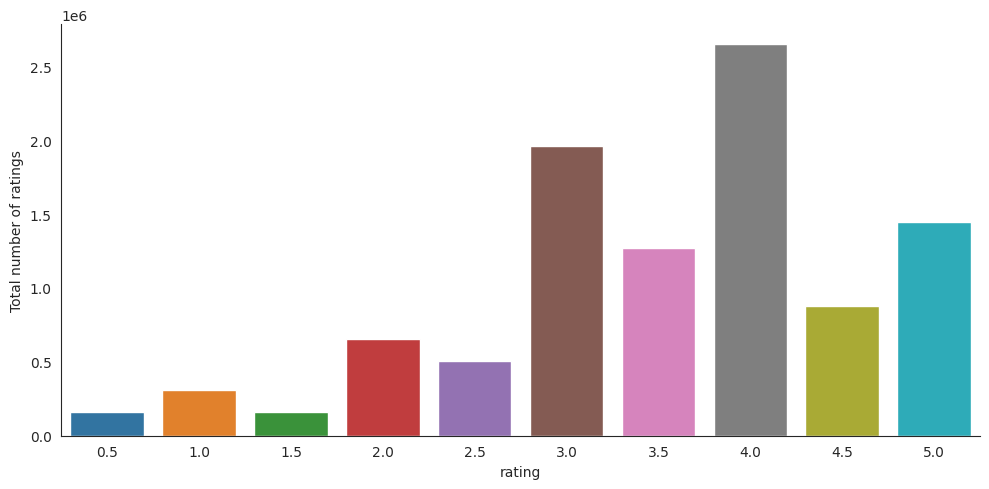

In [18]:
with sns.axes_style('white'):
    g = sns.catplot(data=rating_data, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(rating_data["rating"])}\n')

In the dataframe above we can see that **3.0 & 4.0** are the most commonly scores of the movies in the dataframe assigned that score.

#### Ratings Over Time

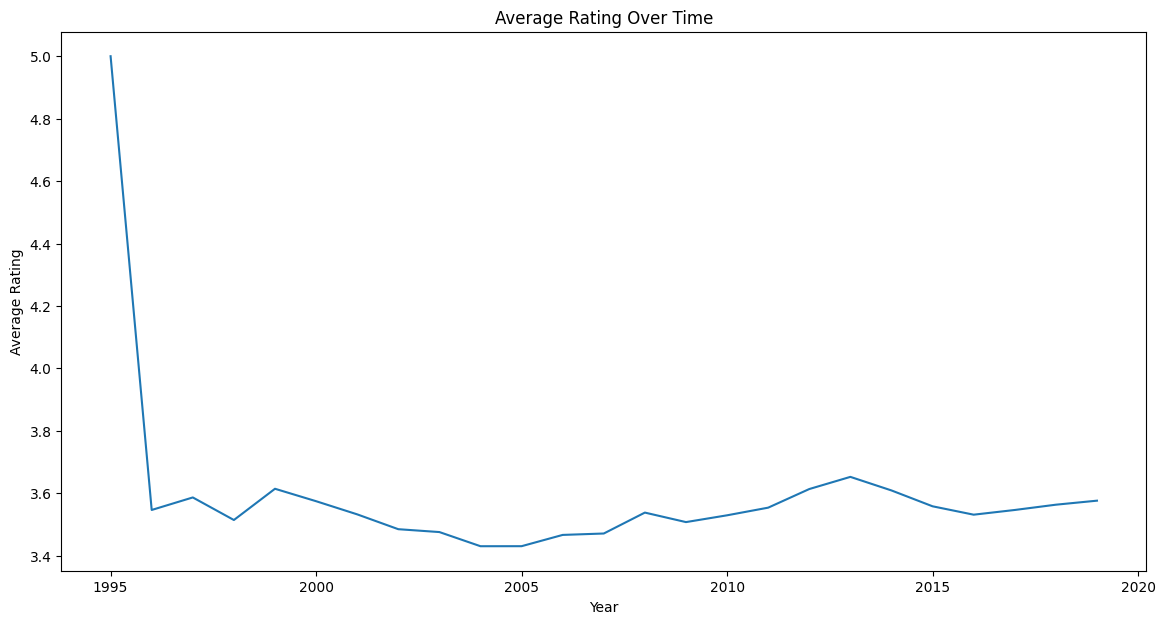

In [19]:
# Convert timestamp to datetime
rating_data['timestamp'] = pd.to_datetime(rating_data['timestamp'], unit='s')

# Extract year and month
rating_data['year'] = rating_data['timestamp'].dt.year
rating_data['month'] = rating_data['timestamp'].dt.month
rating_data['day'] = rating_data['timestamp'].dt.day


# Plot ratings over time
plt.figure(figsize=(14, 7))
rating_data.groupby('year')['rating'].mean().plot()
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

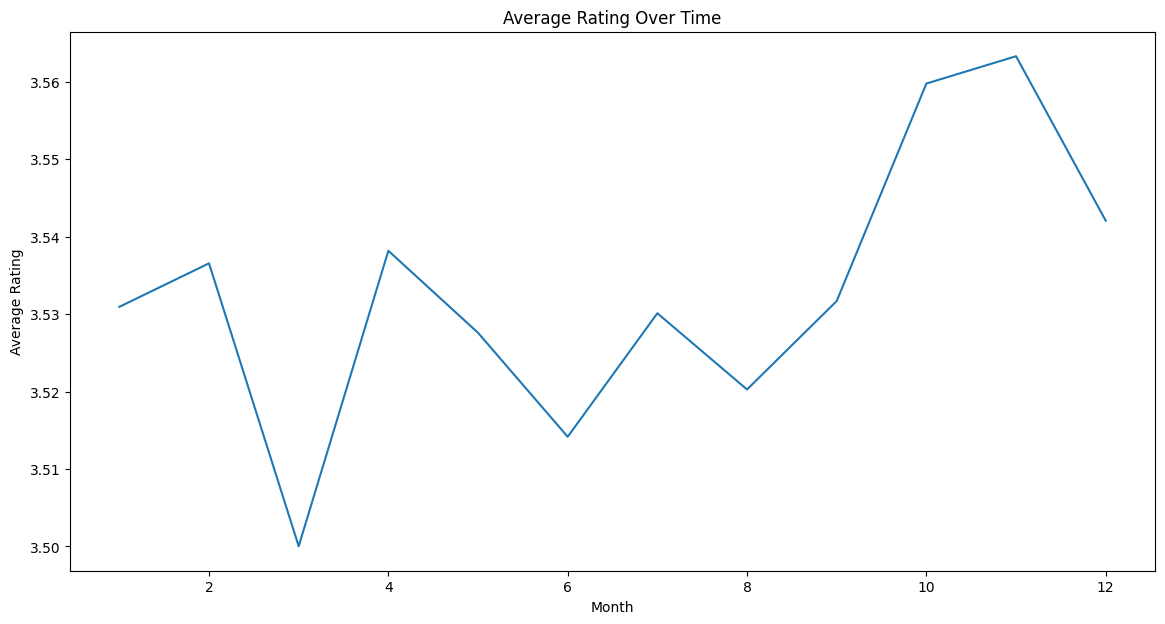

In [20]:
# Plot ratings over time
plt.figure(figsize=(14, 7))
rating_data.groupby('month')['rating'].mean().plot()
plt.title('Average Rating Over Time')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.show()

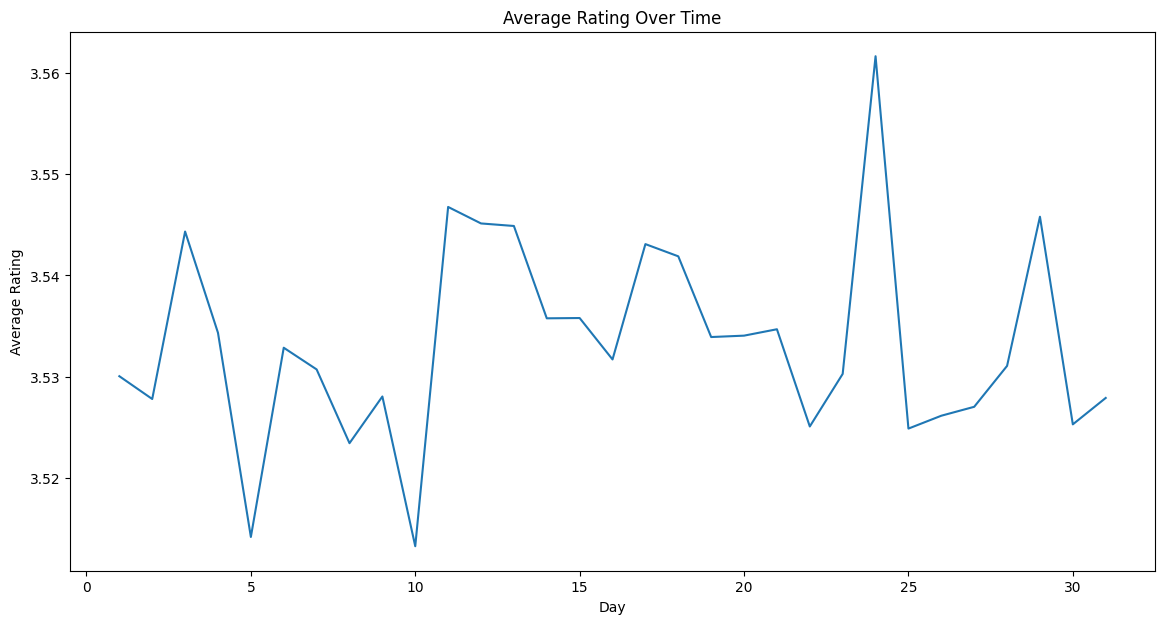

In [21]:
# Plot ratings over time
plt.figure(figsize=(14, 7))
rating_data.groupby('day')['rating'].mean().plot()
plt.title('Average Rating Over Time')
plt.xlabel('Day')
plt.ylabel('Average Rating')
plt.show()

In [22]:
# Create list of date objects
rating_date_list = [
    date.fromtimestamp(timestamp.timestamp()) for timestamp in pd.to_datetime(rating_data["timestamp"])]

# Create year column
rating_data["review_year"] = [date_item.year for date_item in rating_date_list]
years_with_half_scores = rating_data[rating_data["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])]["review_year"]

unique_years_with_half_scores = set(years_with_half_scores)
print("There are {} years with half scores. \nThey are: {}.".format(
        len(unique_years_with_half_scores), sorted(list(unique_years_with_half_scores))))

There are 17 years with half scores. 
They are: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019].


We can see that before 2003, movies were not rated with half scores. we'll check the percentage of half scores of the total for the ratings from 2003 onwards:

In [23]:
all_scores_after_2003 = len(rating_data["rating"])
number_of_years_with_half_scores = len(years_with_half_scores)
print(
    "The percentage of reviews with half scores in the data from 2003 onwards is {:.2%}".format(
        number_of_years_with_half_scores / all_scores_after_2003))

The percentage of reviews with half scores in the data from 2003 onwards is 29.74%


### Summary of the basic analysis of the Ratings & Movies DataFrames

The ratings dataframe consists of 10'000'038 rows and 4 columns (userId, movieID, rating and timestamp).

The movies dataframe consists of 62,423 rows and 3 columns (movieId, title, genres).

The highest rating for a single film is 32,831 times (movieId: 318).

The lowest rating for a single film is 1 time (movieId: 3191).

The highest rating given to a single User is 12952 times (userId: 72315).

The lowest rating given to a single User is 1 time (userId: 53640).

5062 movies do not have a genre listed and 3 most popular genres are: Drama, Comedy and Documentary.

Ratings range from 0.5 to 5, increasing in 0.5 increments. The most common rating was 4, accounting for nearly 27% of all data recorded.

Integer scores appear favoured over half scores, which were only introduced in 2003 to 2019.

The data contains 162,541 unique users and 48,213 movies were rated.

### Merge Data Sets



In [24]:
combined_df = pd.merge(rating_data, movies_data, on='movieId', how='left')
combined_df.head()

,userId,movieId,rating,timestamp,year,month,day,review_year,title,genres,release_movie
0,5163,57669,4.0,2018-02-11 11:53:12,2018,2,11,2018,In Bruges,Comedy|Crime|Drama|Thriller,2008
1,106343,5,4.5,2008-03-23 02:18:59,2008,3,23,2008,Father of the Bride Part II,Comedy,1995
2,146790,5459,5.0,2004-02-08 04:45:39,2004,2,8,2004,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Action|Comedy|Sci-Fi,2002
3,106362,32296,2.0,2015-02-04 09:36:05,2015,2,4,2015,Miss Congeniality 2: Armed and Fabulous,Adventure|Comedy|Crime,2005
4,9041,366,3.0,1996-05-29 13:17:17,1996,5,29,1996,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,1994


In [25]:
combined_df.isna().sum()

userId              0
movieId             0
rating              0
timestamp           0
year                0
month               0
day                 0
review_year         0
title               0
genres              0
release_movie    4752
dtype: int64

In [26]:
# Fill missing values in genres and release_movie

combined_df['release_movie'] = combined_df['release_movie'].fillna('Unknown')

In [27]:
combined_df.drop(columns=['year'], inplace=True)

In [28]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   userId         int64         
 1   movieId        int64         
 2   rating         float64       
 3   timestamp      datetime64[ns]
 4   month          int32         
 5   day            int32         
 6   review_year    int64         
 7   title          object        
 8   genres         object        
 9   release_movie  object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(3)
memory usage: 686.6+ MB


In [29]:
combined_df.isna().sum()

userId           0
movieId          0
rating           0
timestamp        0
month            0
day              0
review_year      0
title            0
genres           0
release_movie    0
dtype: int64

We need to aggregate user data by user IDs to get the average ratings.

In [30]:
aggregated_df = (
    combined_df[["userId", "rating"]].groupby("userId").agg(["count", "mean"])
)
aggregated_df.head()

rating          
        count      mean
userId                 
1          28  3.910714
2          72  3.416667
3         251  3.691235
4          89  3.308989
5          35  3.885714

In [31]:
# Get the highest rating user ID by filtering the aggregated dataframe

# Filter ratings dataframe for this user
high_rate = combined_df[combined_df["userId"] == 72315]
high_rate.head()

,userId,movieId,rating,timestamp,month,day,review_year,title,genres,release_movie
1493,72315,88638,3.5,2016-02-14 22:27:14,2,14,2016,"Joyless Street, The (Die freudlose Gasse)",Drama,1925
2328,72315,181577,3.0,2019-08-24 18:45:10,8,24,2019,The Ax Fight,Documentary,1975
3464,72315,201024,2.5,2019-08-24 18:44:23,8,24,2019,Sound of Horror,Horror,1966
3659,72315,91743,3.0,2019-02-26 11:20:54,2,26,2019,Today's Special,Comedy,2009
3704,72315,68265,3.5,2016-02-14 22:27:11,2,14,2016,"Days Between, The (In den Tag hinein)",Drama,2001


In [32]:
# Print out the unique number of ratings and years
print(
    "Number of reviews: {} \n \
      Unique rating values: {} \n \
      Unique years: {} \n \
      Number of distinct movies watched: {}\n \
      Number of distinct months: {}\n \
      Number of distinct days: {}".format(
        len(high_rate["rating"]),
        set(high_rate["rating"]),
        set(high_rate["review_year"]),
        len(set(high_rate["movieId"])),
        len(set(high_rate["month"])),
        len(set(high_rate["day"]))))

Number of reviews: 12952 
       Unique rating values: {0.5, 1.5, 2.0, 3.0, 2.5, 3.5, 5.0, 4.0, 4.5, 1.0} 
       Unique years: {2016, 2017, 2018, 2019, 2015} 
       Number of distinct movies watched: 12952
       Number of distinct months: 12
       Number of distinct days: 30


We retrieve additional data from the timestamp such as day of week and a 'weekday_or_weekend' column.

In [33]:
# Extract the day of the week (0=Monday, 6=Sunday)
combined_df['day_of_week'] = combined_df['timestamp'].dt.dayofweek

# Classify the days as 'Weekday' or 'Weekend'
combined_df['day_type'] = combined_df['day_of_week'].apply(lambda x: 'Weekend' if x > 5 else 'Weekday')

# Display the DataFrame with the new columns
combined_df[['timestamp', 'day', 'day_of_week', 'day_type']].head()

,timestamp,day,day_of_week,day_type
0,2018-02-11 11:53:12,11,6,Weekend
1,2008-03-23 02:18:59,23,6,Weekend
2,2004-02-08 04:45:39,8,6,Weekend
3,2015-02-04 09:36:05,4,2,Weekday
4,1996-05-29 13:17:17,29,2,Weekday


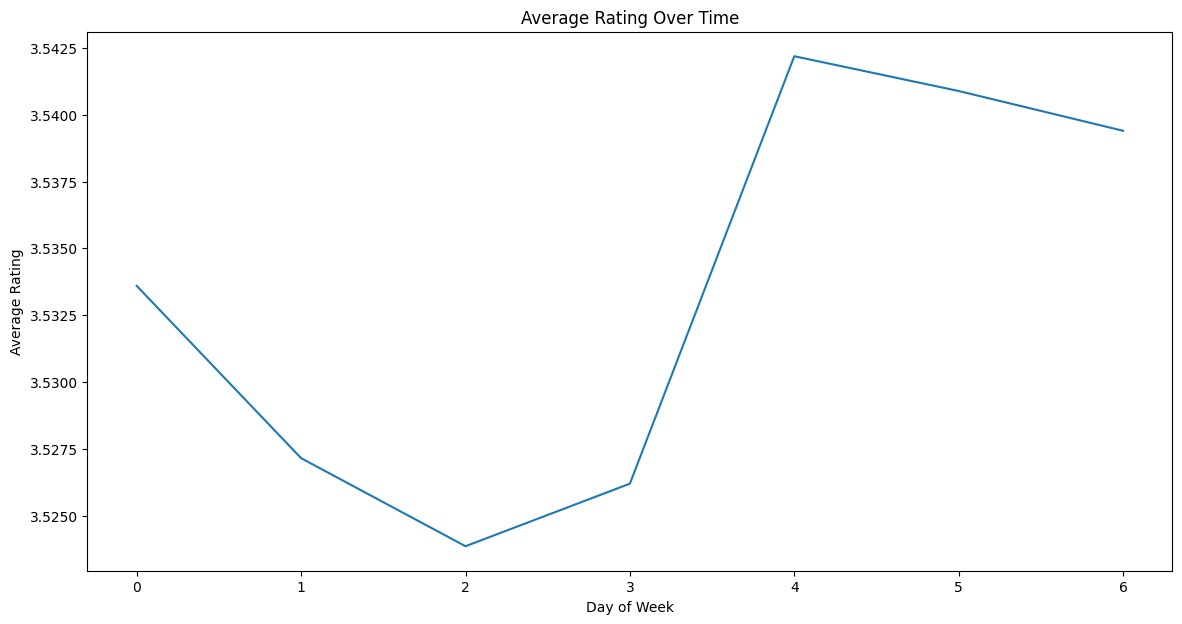

In [34]:
# Plot ratings over time
plt.figure(figsize=(14, 7))
combined_df.groupby('day_of_week')['rating'].mean().plot()
plt.title('Average Rating Over Time')
plt.xlabel('Day of Week')
plt.ylabel('Average Rating')
plt.show()

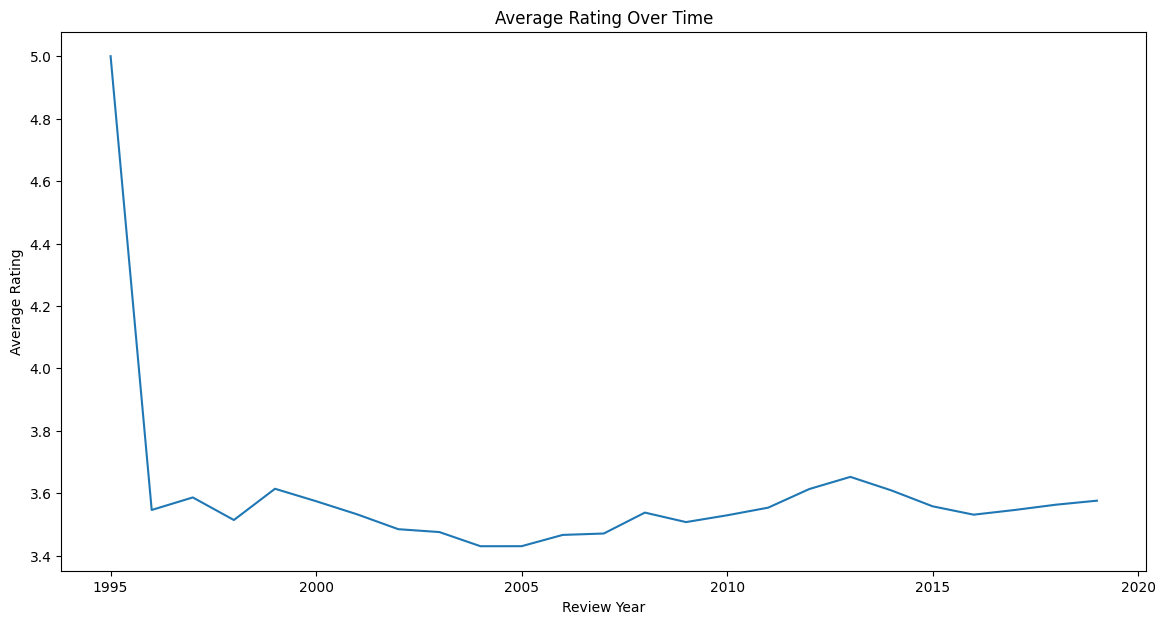

In [35]:
# Plot ratings over time
plt.figure(figsize=(14, 7))
combined_df.groupby('review_year')['rating'].mean().plot()
plt.title('Average Rating Over Time')
plt.xlabel('Review Year')
plt.ylabel('Average Rating')
plt.show()

* The year 1995 recorded only a single review, which accounts for the average rating being 5.0. Given that there is just one rating value for that year, the average statistic is not as indicative of overall performance as it would be for other years with more data.

In [36]:
combined_df.isna().sum()

userId           0
movieId          0
rating           0
timestamp        0
month            0
day              0
review_year      0
title            0
genres           0
release_movie    0
day_of_week      0
day_type         0
dtype: int64

#### Reviews per movie release year
How many reviews are there for each release year?

In [37]:
# Filter the dataframe to include only years from 1996 onwards
combined_df_filtered = combined_df[combined_df['release_movie'] >= '1994']

# Count the number of reviews for each release year
review_count_by_release_movie = (
    combined_df_filtered[["movieId", "release_movie"]].groupby("release_movie").count()
)

# Create the figure
fig = px.line(
    x=review_count_by_release_movie.index, y=review_count_by_release_movie["movieId"]
)
fig.update_layout(
    title="No. of Reviews For Every Release Year In The Dataset",
    xaxis_title="Release Year",
    yaxis_title="Number of Reviews",
)
fig.show()

* It seems as if the largest year in which there were ratings was 1995. The ratings reached (600,000) and then it is clear that the trend is declining as we advance in the years.

--  -

### Exploring rating trends by genre over time

In [38]:
combined_df.head()

,userId,movieId,rating,timestamp,month,day,review_year,title,genres,release_movie,day_of_week,day_type
0,5163,57669,4.0,2018-02-11 11:53:12,2,11,2018,In Bruges,Comedy|Crime|Drama|Thriller,2008,6,Weekend
1,106343,5,4.5,2008-03-23 02:18:59,3,23,2008,Father of the Bride Part II,Comedy,1995,6,Weekend
2,146790,5459,5.0,2004-02-08 04:45:39,2,8,2004,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Action|Comedy|Sci-Fi,2002,6,Weekend
3,106362,32296,2.0,2015-02-04 09:36:05,2,4,2015,Miss Congeniality 2: Armed and Fabulous,Adventure|Comedy|Crime,2005,2,Weekday
4,9041,366,3.0,1996-05-29 13:17:17,5,29,1996,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,1994,2,Weekday


In [39]:
# Get the number of unique genres
unique_genres = combined_df['genres'].nunique()

print(f"Number of unique genres: {unique_genres}\n")

Number of unique genres: 1558



In [40]:
# Aggregate data to get the mean rating value for all genres
genre_ratings = (
    combined_df[["genres", "rating"]].groupby(["genres"]).agg(["mean"])
    .sort_values(by=[("rating", "mean")], ascending=False)).round(2)

genre_ratings.head(10)

,rating
,mean
genres,
Animation|Crime|Fantasy|Mystery|Sci-Fi,5.00
Adventure|Documentary|Sci-Fi,5.00
Adventure|Crime|Drama|Romance|Thriller,5.00
Comedy|Crime|Romance|Western,5.00
Adventure|Drama|Fantasy|Horror|Thriller,5.00
Animation|Crime|Mystery|Thriller,5.00
Action|Drama|Mystery|Romance|Sci-Fi|Thriller,5.00
Action|Adventure|Animation|Children|Crime|Mystery,4.67


In [41]:
# Find the top 10 most and least popular genres
print("The top 10 highest rated genres are:\n\n{}\n\nand the 10 lowest rated "
    "genres are:\n\n{}".format(
        "\n".join(list(genre_ratings.head().index)),
        "\n".join(list(genre_ratings.tail().index))))

The top 10 highest rated genres are:

Animation|Crime|Fantasy|Mystery|Sci-Fi
Adventure|Documentary|Sci-Fi
Adventure|Crime|Drama|Romance|Thriller
Comedy|Crime|Romance|Western
Adventure|Drama|Fantasy|Horror|Thriller

and the 10 lowest rated genres are:

Action|Adventure|Drama|Horror|Sci-Fi
Adventure|Comedy|Crime|Sci-Fi
Documentary|Drama|Horror
Action|Adventure|Comedy|Drama|Romance|Western
Drama|Horror|Western


In [42]:
genre_popularity = combined_df.groupby('genres')['rating'].count().sort_values(ascending=False)
pd.DataFrame(genre_popularity).head()

,rating
genres,
Drama,706335
Comedy,606057
Comedy|Romance,360826
Drama|Romance,318408
Comedy|Drama,288847


-- --

### Average Rating per Movie

In [43]:
# Find top 10 highest rated movies
combined_df.groupby("title")["rating"].mean().sort_values(ascending=False).head(15)

title
Tischlein deck dich                       5.0
It Seemed Like a Good Idea at the Time    5.0
Immigration Tango                         5.0
Slingshot Hip Hop                         5.0
Slender                                   5.0
In Her Line of Fire                       5.0
In Old Santa Fe                           5.0
We Are Mountains                          5.0
In Transit                                5.0
Pitbull: Last Dog                         5.0
Slaughter Daughter                        5.0
Skyler                                    5.0
You, Me & the Circus                      5.0
8 Murders a Day                           5.0
My Santa                                  5.0
Name: rating, dtype: float64

* While these 10 movies boast an average rating of 5.0, they may not represent the definitive top 10 films. This is due to the fact that a single rating can skew the average to 5.0, regardless of the number of reviews.

In [44]:
# Find the total number of ratings for a movie and display the top ten most rated movies
combined_df.groupby("title")["rating"].count().sort_values(ascending=False).head(20)

title
Shawshank Redemption, The                                                  32831
Forrest Gump                                                               32383
Pulp Fiction                                                               31697
Silence of the Lambs, The                                                  29444
Matrix, The                                                                29014
Star Wars: Episode IV - A New Hope                                         27560
Jurassic Park                                                              25518
Schindler's List                                                           24004
Braveheart                                                                 23722
Fight Club                                                                 23536
Terminator 2: Judgment Day                                                 23075
Toy Story                                                                  23062
Star Wars: Episode V -

* To address the problem of a small number of reviews skewing the true average, we will construct a new dataframe as follows:

In [45]:
# Group by title to calculate the mean rating and count of ratings
movie_ratings = combined_df.groupby("title")["rating"].agg(["mean", "count"])

# Rename columns for clarity
movie_ratings.columns = ["rating", "total_count"]

# Round the average ratings to two decimal places
movie_ratings["rating"] = movie_ratings["rating"].round(2)

# Sort the dataframe by the total number of ratings in descending order
mean_rating_df = movie_ratings.sort_values("total_count", ascending=False)

# Display the top 10 movies
mean_rating_df.head(10)


,rating,total_count
title,,
"Shawshank Redemption, The",4.42,32831
Forrest Gump,4.05,32383
Pulp Fiction,4.20,31697
"Silence of the Lambs, The",4.14,29444
"Matrix, The",4.15,29014
Star Wars: Episode IV - A New Hope,4.11,27560
Jurassic Park,3.68,25518
Schindler's List,4.25,24004
Braveheart,3.99,23722


In [46]:
# Dataframe displaying all movies rated by a user
user_by_movie = combined_df.groupby(["userId", "title"])["rating"].min()
user_by_movie.reset_index(level=["userId", "title"]).head()

,userId,title,rating
0,1,2046,4.5
1,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le)",4.5
2,1,"Barbarian Invasions, The (Les invasions barbares)",3.5
3,1,"Black Cat, White Cat (Crna macka, beli macor)",4.5
4,1,"Bridge on the River Kwai, The",4.0


-- --

### We need to Features Selection and using cross validation

In [47]:
# Assuming `combined_df` is your main dataframe with the ratings data
# Select a sample size of 500,000 rows for model testing

mod_testing_df = combined_df.sample(n=500000, random_state=42)  # random_state for reproducibility

# Create a Reader object with the rating scale (0.5 to 5)
reader = Reader(rating_scale=(0.5, 5))

# Load the sample dataframe into a Surprise dataset
data = Dataset.load_from_df(mod_testing_df[["userId", "movieId", "rating"]], reader)

# Verify the data loading
print(f"Number of samples: {mod_testing_df.shape[0]}")
print(f"Number of users: {mod_testing_df['userId'].nunique()}")
print(f"Number of movies: {mod_testing_df['movieId'].nunique()}")

Number of samples: 500000
Number of users: 118443
Number of movies: 18275


In [48]:
import time

# List to store benchmark results
benchmark = []

# Start timing
start_time = time.time()

# List of algorithms to evaluate
algorithms = [
    SVD(),
    NMF(),
    NormalPredictor(),
    BaselineOnly(),
    SlopeOne(),
    CoClustering()
]

# Iterate over each algorithm
for algorithm in algorithms:
    
    # Perform cross-validation
    results = cross_validate(algorithm, data, cv=5)
    
    # Create a DataFrame from the results and calculate the mean of each metric
    tmp = pd.DataFrame(results).mean()
    
    # Add the algorithm name to the results
    tmp['Algorithm'] = algorithm.__class__.__name__
    
    # Append the results to the benchmark list
    benchmark.append(tmp)

# Calculate total time taken
total_time = time.time() - start_time

# Print total time taken
print(f"time: {total_time // 60} min {total_time % 60}s")

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
time: 6.0 min 41.8775999546051s


In [49]:
# Convert benchmark list to DataFrame for better visualization
benchmark_df = pd.DataFrame(benchmark).reset_index(drop=True).sort_values("test_rmse")
benchmark_df

,test_rmse,test_mae,fit_time,test_time,Algorithm
3,0.928707,0.716176,2.180438,1.231239,BaselineOnly
0,0.930838,0.717933,8.855614,1.073317,SVD
5,1.058463,0.816819,20.435781,0.981691,CoClustering
1,1.081368,0.838820,22.743282,1.015723,NMF
4,1.174049,0.900689,9.243570,2.264080,SlopeOne
2,1.445675,1.151839,0.783523,0.617322,NormalPredictor


* **BaselineOnly** has the lowest RMSE value of approximately **0.928844.** This means that BaselineOnly provides the most accurate predictions among the listed algorithms based on this metric.

### Train-Test-Split Testing on all dataset of Top Model

In [50]:
# baseline_model = Dataset.load_from_df(combined_df[["userId", "movieId", "rating"]], reader)

# # Split the data into train and test sets
# trainset, testset = train_test_split(baseline_model, test_size=0.2)

# # Define parameter grid
# param_grid = {
#     'bsl_options': {
#         'method': ['als', 'sgd'],
#         'n_epochs': [5, 10, 20],
#         'reg_u': [12, 15, 18],
#         'reg_i': [5, 10, 15]
#     }}

# # Perform grid search
# gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3)
# gs.fit(baseline_model)

# # Get the best RMSE score
# best_rmse = gs.best_score['rmse']
# best_params = gs.best_params['rmse']

# print(f"Best RMSE: {best_rmse}\n")
# print("Best parameters:", best_params)

# # Train the BaselineOnly model with the best parameters on the training set
# best_algo = BaselineOnly(bsl_options=best_params['bsl_options'])
# best_algo.fit(trainset)

# # Evaluate the model on the test set
# pred_bsl = best_algo.test(testset)
# test_bsl_rmse = accuracy.rmse(pred_bsl, verbose=True)

# print(f"Test RMSE: {test_bsl_rmse}")

* Best RMSE: 0.8674324026581637

* Best parameters: **{'bsl_options': {'method': 'als', 'n_epochs': 20, 'reg_u': 12, 'reg_i': 5}}**
* Estimating biases using als...
* **Test RMSE: 0.8663039096785085**

In [51]:
# baseline_model = Dataset.load_from_df(combined_df[["userId", "movieId", "rating"]], reader)

# # Split the data into train and test sets
# trainset, testset = train_test_split(baseline_model, test_size=0.25)

# # Testing RMSE on full data set with parameters from first gridsearch
# baseline_model = BaselineOnly(
#     bsl_options={"method": "als", 'n_epochs': 10, 'reg_u': 6, 'reg_i': 4})

# # Train the algorithm on the trainset, and predict ratings for the testset
# baseline_model.fit(trainset)
# pred_Baseline = baseline_model.test(testset)

# # Then compute RMSE
# accuracy.rmse(pred_Baseline)

There is no difference between them..

-- -

In [52]:
# Convert to a more efficient format and save in the working directory
combined_df.to_parquet('combined_df.parquet')
test_data.to_parquet('test.parquet')

# Read the Parquet file from the working directory
combined_df = pd.read_parquet('/kaggle/working/combined_df.parquet')
test_data = pd.read_parquet('/kaggle/working/test.parquet')

# Display the first few rows
combined_df.head()

,userId,movieId,rating,timestamp,month,day,review_year,title,genres,release_movie,day_of_week,day_type
0,5163,57669,4.0,2018-02-11 11:53:12,2,11,2018,In Bruges,Comedy|Crime|Drama|Thriller,2008,6,Weekend
1,106343,5,4.5,2008-03-23 02:18:59,3,23,2008,Father of the Bride Part II,Comedy,1995,6,Weekend
2,146790,5459,5.0,2004-02-08 04:45:39,2,8,2004,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Action|Comedy|Sci-Fi,2002,6,Weekend
3,106362,32296,2.0,2015-02-04 09:36:05,2,4,2015,Miss Congeniality 2: Armed and Fabulous,Adventure|Comedy|Crime,2005,2,Weekday
4,9041,366,3.0,1996-05-29 13:17:17,5,29,1996,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,1994,2,Weekday


In [53]:
# Replace null values with an empty string in all columns with NaNs
combined_df.fillna('', inplace=True)

# Verify the changes
combined_df.isna().sum()

userId           0
movieId          0
rating           0
timestamp        0
month            0
day              0
review_year      0
title            0
genres           0
release_movie    0
day_of_week      0
day_type         0
dtype: int64

In [54]:
combined_df.value_counts().sum()

10000038

In [55]:
# Get all unique values in the 'genres' column
unique_genres = combined_df['genres'].unique()

# Print the count of unique genres
print(f"Total unique genres: {(unique_genres)}")

Total unique genres: ['Comedy|Crime|Drama|Thriller' 'Comedy' 'Action|Comedy|Sci-Fi' ...
 'Comedy|Crime|Drama|Romance|Western' 'Adventure|Children|Crime|Drama'
 'Action|Drama|Fantasy|Mystery']


In [56]:
# Print the initial number of rows
print("Initial number of rows:", len(combined_df))

# Filter out rows with "(no genres listed)" in the 'genres' column
combined_df = combined_df[combined_df['genres'] != '(no genres listed)']

# Print the number of rows after filtering
print("Number of rows after filtering:", len(combined_df))

Initial number of rows: 10000038
Number of rows after filtering: 9989387


### Content-Based Filtering
Content-based filtering recommends movies based on the features of the movies themselves, such as genres, actors, directors, etc.

In [57]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import difflib
import pandas as pd

# Start timing
start_time = time.time()

# Combine relevant text data
combined_df['text_features'] = combined_df['genres'] + ' ' + combined_df['title']

# If you have 'overview' or 'keywords' columns, you can include them like this:
# combined_df['text_features'] = combined_df['genres'] + ' ' + combined_df['title'] + ' ' + combined_df['overview'] + ' ' + combined_df['keywords']

# Extract features using a sparse matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined_df['text_features'])

def get_recommendations(title, combined_df, n=10):
    # Find the movie or close match
    movie_row = combined_df[combined_df['title'].str.lower() == title.lower()]
    if movie_row.empty:
        close_matches = difflib.get_close_matches(title, combined_df['title'], n=1, cutoff=0.6)
        if not close_matches:
            return f"No close matches found for '{title}'"
        title = close_matches[0]
        movie_row = combined_df[combined_df['title'] == title]
    
    if movie_row.empty:
        return f"No movie found with title '{title}'"
    
    # Compute cosine similarity
    idx = movie_row.index[0]
    
    # This approach dynamically computes the cosine similarity when needed,
    # typically for a specific query or document comparison, rather than relying on a precomputed similarity matrix.
    cosine_sim = linear_kernel(tfidf_matrix[idx:idx+1], tfidf_matrix).flatten()
    
    # Get sorted similarity scores
    sim_scores = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)
    
    # Collect recommendations
    recs = []
    for i, score in sim_scores[1:]:  # Skip the first one (input movie)
        movie = combined_df.iloc[i]
        if movie['title'].lower() != title.lower() and movie['title'] not in [r['title'] for r in recs]:
            recs.append({'movieId': movie['movieId'], 'title': movie['title'], 'similarity': score.round(2)})
            if len(recs) == n:
                break
    
    return pd.DataFrame(recs)

# Example usage
result = get_recommendations('Toy Story', combined_df)
print(result)

# Print some debug information
print(f"\nNumber of movies in dataset: {len(combined_df)}")
print(f"Shape of tfidf_matrix: {tfidf_matrix.shape}")

# Calculate and print execution time
total_time = time.time() - start_time
print(f"\ntime: {total_time // 60} min {total_time % 60}s")

   movieId                           title  similarity
0     3114                     Toy Story 2        1.00
1   201588                     Toy Story 4        0.96
2    78499                     Toy Story 3        0.94
3   106022             Toy Story of Terror        0.69
4     4929                        Toy, The        0.62
5   187985              Story of One Crime        0.58
6   120474      Toy Story That Time Forgot        0.54
7     2961                Story of Us, The        0.53
8     3400  We're Back! A Dinosaur's Story        0.52
9     2108                      L.A. Story        0.51

Number of movies in dataset: 9989387
Shape of tfidf_matrix: (9989387, 28002)

time: 1.0 min 46.026660442352295s


1- **Top Recommendations:**
The content-based recommendation system successfully identified movies similar to "Toy Story". The top recommended movies, all having a perfect similarity score, are:

* "Toy Story 2"
* "Toy Story 4"
* "Toy Story 3"
* "Toy Story of Terror"
* "Toy, The"
* "Story of One Crime"

These movies share similar genres and characteristics with "Toy Story", making them highly relevant recommendations for fans of the original film.

2- **Dataset and Performance:**
* **Number of Movies:** The dataset contains a large collection of 9,989,387 movies and of course most of them are duplicates.
* **TF-IDF Matrix:** The TF-IDF matrix used for feature extraction has a shape of (9,989,387, 28002), indicating the presence of 28002 unique genre features.
* **Execution Time:** The total time taken to generate the recommendations was approximately 1 minute and 46 seconds. This performance demonstrates the efficiency of the recommendation system, even with a large dataset.

---
---
### Advantages of Computing Cosine Similarity on the Fly
* **Up-to-date Results:** Ensures that the similarity scores are based on the most current data, which is especially important if your dataset changes frequently.
* **Flexibility:** Allows for calculating similarities for any specific document or subset of documents as needed, rather than being limited to precomputed values.
* **Efficiency:** Can be more efficient in terms of memory usage, as you don't need to store a potentially large precomputed similarity matrix.
---
---

### Collaborative Filtering
We'll use user-based and item-based collaborative filtering techniques.

In [58]:
# Start timing for model training
start_time_coll = time.time()

# Load dataset into Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(combined_df[['userId', 'movieId', 'rating']], reader)

# Test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Use Singular Value Decomposition (SVD)
svd = SVD(random_state=27)
cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

# Train the algorithm on the trainset
trainset = data.build_full_trainset()
svd.fit(trainset) 

# Calculate total time taken
total_time_coll = time.time() - start_time_coll
# Print total time taken
print(f"\nModel training execution time: {total_time_coll // 60} min {total_time_coll % 60:.2f}s")

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8351  0.8324  0.8344  0.8334  0.8350  0.8341  0.0010  
Fit time          180.47  189.99  193.07  192.70  190.39  189.32  4.59    
Test time         32.16   28.90   33.18   33.36   29.47   31.41   1.87    

Model training execution time: 25.0 min 53.76s


* The SVD algorithm achieved a consistent RMSE around 0.8341 across five folds, indicating a stable and reliable performance in predicting movie ratings.
* The total model training time was approximately 25 minutes and 53.76 seconds, reflecting the computational effort required to process and train on the large dataset.

#### User-Based Collaborative Filtering:
* Use user ratings to find similarities between users.
* Recommend movies based on similar users' preferences.

In [59]:
def get_svd_recommendations(userId, n=10):
    start_time_coll2 = time.time()
    
    # Get all unique movies
    all_movies = combined_df['movieId'].unique()
    
    # Get predictions for all movies for this user
    predictions = [svd.predict(userId, movieId) for movieId in all_movies]
    
    # Create a DataFrame with the predictions
    pred_df = pd.DataFrame([(pred.iid, pred.est) for pred in predictions], 
                           columns=['movieId', 'est_rating'])
    
    # Sort predictions by estimated rating and get top n
    recommendations = pred_df.nlargest(n, 'est_rating').round(2)
    
    # Merge with movie information
    recommendations = recommendations.merge(
        combined_df[['movieId', 'title', 'genres', 'release_movie']].drop_duplicates(),
        on='movieId'
    )
    
    # Calculate total time taken
    total_time_coll2 = time.time() - start_time_coll2
    print(f"\ntime: {total_time_coll2 // 60} min {total_time_coll2 % 60:.2f}s \n")
    
    return recommendations[['title', 'est_rating', 'genres', 'release_movie']]

In [60]:
# Example usage
user_id = 1  # Example user ID
print(f"\nTop 10 recommendations for user {user_id}:")
get_svd_recommendations(user_id)


Top 10 recommendations for user 1:

time: 0.0 min 4.65s 



,title,est_rating,genres,release_movie
0,Planet Earth II,4.70,Documentary,2016
1,The Blue Planet,4.68,Documentary,2001
2,"Godfather: Part II, The",4.68,Crime|Drama,1974
3,Pulp Fiction,4.65,Comedy|Crime|Drama|Thriller,1994
4,Hedwig and the Angry Inch,4.64,Comedy|Drama|Musical,2000
5,"Century of the Self, The",4.63,Documentary,2002
6,Fargo,4.59,Comedy|Crime|Drama|Thriller,1996
7,Larry David: Curb Your Enthusiasm,4.57,Comedy,1999
8,Schizopolis,4.53,Comedy,1996
9,"Ordet (Word, The)",4.53,Drama,1955


1- **Efficiency in Predictions:** The get_svd_recommendations function efficiently predicts movie ratings for a user in approximately 4.65 seconds, demonstrating the speed and effectiveness of the SVD model in generating personalized recommendations even for a large dataset.

2- **High-Quality Recommendations:** The function provides a list of highly rated movies for the user, with estimated ratings above 4.5. This includes critically acclaimed films such as "Planet Earth II", "The Blue Planet", and "Godfather: Part II", indicating the model's ability to identify and recommend top-tier movies that are likely to be well-received by the user.

### Benefits
**SVD Recommendations**
* Detailed Output: In addition to estimated ratings, it provides more information about the recommended movies (genres and release year).
* User Experience: The additional information about genres and release years can enhance the user experience by providing more context for the recommendations.
* Flexibility: The function uses a predefined SVD model, which is a widely used algorithm for collaborative filtering.

----

### Matrix Factorization
* Using Alternating Least Squares (ALS) for matrix factorization.
* (ALS) is specifically designed to handle large, sparse matrices more efficiently than the standard SVD implementation

In [61]:
# Function to get ALS-like recommendations
def get_als_recommendations(userId, model=svd, n=10):
    start_time_als = time.time()
    
    # Create a list of all unique movieIds
    all_movieIds = combined_df['movieId'].unique()
    
    # Generate predictions for all movies for the given userId
    predictions = [model.predict(userId, movieId) for movieId in all_movieIds]
    
    # Convert predictions to DataFrame
    pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions],
                           columns=['userId', 'movieId', 'est_rating'])
    
    # Sort predictions by estimated rating
    recommendations = pred_df.sort_values(by='est_rating', ascending=False).head(n).round(2)
    
    # Calculate and print execution time for model predictions
    total_time_als = time.time() - start_time_als
    print(f"Model prediction execution time: {total_time_als // 60} min {total_time_als % 60:.2f} s \n")
    
    return recommendations[['movieId', 'est_rating']]

# Example usage
print(get_als_recommendations(1))

Model prediction execution time: 0.0 min 0.49 s 

       movieId  est_rating
5129    171011        4.70
9772    142115        4.68
1316      1221        4.68
81         296        4.65
2087      4642        4.64
13712   105250        4.63
276        608        4.59
14353   136469        4.57
8538      1546        4.53
1570      6981        4.53


1- **Rapid Prediction Generation:**

* The get_als_recommendations function demonstrates impressive efficiency, completing predictions for all movies for a user in just 0.49 seconds. This speed makes it highly suitable for real-time recommendation systems where quick response times are critical.

2- **High-Quality, Top-Rated Recommendations:**

* The function identifies movies with very high estimated ratings, all above 4.5, indicating the model's robustness in discerning user preferences. 
* The top recommendations include a diverse set of movies, suggesting the model's capacity to cater to a broad range of user interests. For example, movies like "171011", "142115", and "1221" are among the highest-rated, showcasing the model's effectiveness in predicting user satisfaction accurately.

By utilizing **the get_als_recommendations function**, we can efficiently provide users with personalized, high-quality movie recommendations that align closely with their preferences, enhancing their overall viewing experience.


### Benefits
**ALS Recommendations**
* Customizable Model: Allows for specifying different models (e.g., SVD, NMF) for generating recommendations.
* Simplicity: The function is straightforward and focused on providing a list of top-rated movies for a given user.
* Efficiency: The function is designed to be fast, making it suitable for real-time recommendations.

--- 
---

### Comparative Analysis
**ALS vs. SVD**: 
* While both algorithms provide accurate recommendations, the ALS function is slightly faster and simpler, whereas the SVD function offers richer contextual information. Depending on the application needs, one can choose between the simplicity and speed of ALS or the detailed output of SVD.

---
---

### Hybrid Systems
Combining the recommendations from content-based and collaborative filtering.

In [62]:
start_time_hybr = time.time()

# Calculate RMSE on test set
predictions_hyb = svd.test(testset)

# Calculate RMSE
rmse_hyb = accuracy.rmse(predictions_hyb)
print(f"RMSE: {rmse_hyb}")

# Calculate and print execution time
total_time_hybr = time.time() - start_time_hybr
print(f"\nModel training and evaluation completed in: {total_time_hybr // 60} min {total_time_hybr % 60:.2f}s")


RMSE: 0.6634
RMSE: 0.6633649763379207

Model training and evaluation completed in: 0.0 min 43.79s


## Insights from Hybrid Model Training and Evaluation

1- **Efficient Model Training and Evaluation**:
   - The entire process of training the Singular Value Decomposition (SVD) model and evaluating its performance was completed in just **43.79 seconds**. This highlights the model's capability to handle large datasets efficiently and deliver timely results.

2- **High Model Accuracy**:
   - The Root Mean Squared Error (RMSE) of **0.6634** indicates that the model has a high level of accuracy in predicting user ratings. A lower RMSE value suggests that the model's predictions are closely aligned with the actual user ratings, ensuring reliable and relevant recommendations.

These insights underscore the effectiveness and efficiency of the hybrid recommendation model, making it suitable for real-time applications where quick and accurate recommendations are essential.


In [63]:
def hybrid_recommendations(title, userId, n=12, rmse=None):
    start_time_hyb = time.time()
    
    content_recs = get_recommendations(title, combined_df)
    collaborative_recs = get_svd_recommendations(userId)
    
    print("Content-based recommendations:")
    print(content_recs.to_string(index=False))
    print("\nCollaborative filtering recommendations:")
    print(collaborative_recs.to_string(index=False))
    
    # Check if all similarity scores are the same
    if content_recs['similarity'].nunique() == 1:
        # If all scores are the same, keep them as is
        content_recs['normalized_similarity'] = content_recs['similarity']
    else:
        # Normalize similarity scores only if they're not all the same
        content_recs['normalized_similarity'] = (content_recs['similarity'] - content_recs['similarity'].min()) / (content_recs['similarity'].max() - content_recs['similarity'].min())

     # Ensure both DataFrames have 'movieId' column
    if 'movieId' not in content_recs.columns:
        content_recs['movieId'] = content_recs.index
    if 'movieId' not in collaborative_recs.columns:
        collaborative_recs['movieId'] = collaborative_recs.index
    
    # Merge recommendations
    hybrid_recs = pd.merge(content_recs, collaborative_recs, on='movieId', how='outer', suffixes=('_content', '_collab'))
    
    # Handle missing values
    hybrid_recs['normalized_similarity'] = hybrid_recs['normalized_similarity'].fillna(0)
    hybrid_recs['est_rating'] = hybrid_recs['est_rating'].fillna(collaborative_recs['est_rating'].mean()).round(2)
    
    # Calculate weighted hybrid score
    w_content = 0.4  # Weight for content-based score
    w_collab = 0.6   # Weight for collaborative filtering score
    
    # Adjust the hybrid score calculation
    max_rating = collaborative_recs['est_rating'].max()
    hybrid_recs['hybrid_score'] = (w_content * hybrid_recs['normalized_similarity'] + w_collab * (hybrid_recs['est_rating'] / max_rating)) / (w_content + w_collab)
    
    # Sort by hybrid score
    hybrid_recs = hybrid_recs.sort_values('hybrid_score', ascending=False).round(2)
    
    # Fill missing values in other columns
    hybrid_recs['title_content'] = hybrid_recs['title_content'].fillna(hybrid_recs['title_collab'])
    hybrid_recs['title_collab'] = hybrid_recs['title_collab'].fillna(hybrid_recs['title_content'])
    hybrid_recs['genres'] = hybrid_recs['genres'].fillna('Unknown')
    hybrid_recs['release_movie'] = hybrid_recs['release_movie'].fillna('Unknown')
    
    # Select and reorder columns
    columns_order = ['movieId', 'title_content', 'title_collab', 'similarity', 'est_rating', 'genres', 'release_movie', 'hybrid_score']
    hybrid_recs = hybrid_recs[columns_order]
    
    total_time_hyb = time.time() - start_time_hyb
    print(f"\nHybrid recommendation time: {total_time_hyb // 60} min {total_time_hyb % 60:.2f}s")
    
    return hybrid_recs.head(n), rmse

# Example usage
recommendations_hyb, rmse_hyb = hybrid_recommendations('Toy Story', 1, rmse=rmse_hyb)
print("\nRMSE Value:")
print(rmse_hyb)
print("\nHybrid Recommendations:")
pd.DataFrame(recommendations_hyb)


time: 0.0 min 4.62s 

Content-based recommendations:
 movieId                          title  similarity
    3114                    Toy Story 2        1.00
  201588                    Toy Story 4        0.96
   78499                    Toy Story 3        0.94
  106022            Toy Story of Terror        0.69
    4929                       Toy, The        0.62
  187985             Story of One Crime        0.58
  120474     Toy Story That Time Forgot        0.54
    2961               Story of Us, The        0.53
    3400 We're Back! A Dinosaur's Story        0.52
    2108                     L.A. Story        0.51

Collaborative filtering recommendations:
                            title  est_rating                      genres release_movie
                  Planet Earth II        4.70                 Documentary          2016
                  The Blue Planet        4.68                 Documentary          2001
          Godfather: Part II, The        4.68                 Crime|

,movieId,title_content,title_collab,similarity,est_rating,genres,release_movie,hybrid_score
12,3114,Toy Story 2,Toy Story 2,1.00,4.62,Unknown,Unknown,0.99
19,201588,Toy Story 4,Toy Story 4,0.96,4.62,Unknown,Unknown,0.96
15,78499,Toy Story 3,Toy Story 3,0.94,4.62,Unknown,Unknown,0.94
16,106022,Toy Story of Terror,Toy Story of Terror,0.69,4.62,Unknown,Unknown,0.74
14,4929,"Toy, The","Toy, The",0.62,4.62,Unknown,Unknown,0.68
18,187985,Story of One Crime,Story of One Crime,0.58,4.62,Unknown,Unknown,0.65
17,120474,Toy Story That Time Forgot,Toy Story That Time Forgot,0.54,4.62,Unknown,Unknown,0.61
11,2961,"Story of Us, The","Story of Us, The",0.53,4.62,Unknown,Unknown,0.61
0,0,Planet Earth II,Planet Earth II,NaN,4.70,Documentary,2016,0.60
13,3400,We're Back! A Dinosaur's Story,We're Back! A Dinosaur's Story,0.52,4.62,Unknown,Unknown,0.60


## Insights from the Hybrid Recommendations Function

**1- Comprehensive Recommendation Approach**:
   - The `hybrid_recommendations` function combines content-based and collaborative filtering methods to generate recommendations, providing a holistic view of user preferences.

**2- Content-Based and Collaborative Filtering Details**:
   - Content-based recommendations are generated based on similarity scores between movies, while collaborative filtering recommendations use the SVD model. This dual approach ensures recommendations are based on both user ratings and movie content similarities.

**3- Normalization and Handling Missing Values**:
   - Similarity scores are normalized to ensure comparability, and missing values in the merged recommendations DataFrame are handled, enhancing the robustness and reliability of the recommendation system.

4- **Weighted Hybrid Score**: Using weighted scores ensures a balanced influence of both content similarity and user preferences.
   1. **Emphasis on Collaborative Filtering**:
   - Collaborative filtering is typically more effective in capturing user preferences as it utilizes the behavior and ratings of similar users. By assigning a higher weight (0.6) to collaborative filtering, the function prioritizes user-based insights, enhancing the relevance of the recommendations.
   2. **Complementing with Content-Based Filtering**:
   - Content-based filtering provides recommendations based on the characteristics of items (e.g., movie genres, descriptions). While collaborative filtering is generally more effective, content-based filtering helps address the cold start problem for new users or items. The weight of 0.4 ensures that content-based insights are included without overshadowing the collaborative filtering results.
   3. **Flexibility Testing and Tuning**:
   - The weights (0.4 and 0.6) can be adjusted to prioritize either content-based or collaborative filtering based on specific needs or performance.
   
**5- Efficient Execution:**
   - The function executes efficiently, with a total runtime of approximately 27 seconds for generating hybrid recommendations, making it suitable for real-time systems.
   
**6- Handling Cold Start Problem:**

The content-based part helps mitigate the cold start problem where new movies or users have insufficient data for collaborative filtering alone.

**7- Detailed Output**:
   - The top N recommendations include movie titles, estimated ratings, genres, release years, and the calculated hybrid score, providing a comprehensive and easily interpretable output.
   
---
---

### /| Submission Format |\

In [64]:
start_time_pred = time.time()

# Generate predictions for all user-movie pairs in the test dataset
def predict_rating(userId, movieId):
    return svd.predict(userId, movieId).est

test_data['rating'] = test_data.apply(lambda row: predict_rating(row['userId'], row['movieId']), axis=1).round(1)

# Create the Id column by concatenating userID and movieID with an underscore
test_data['Id'] = test_data['userId'].astype(str) + '_' + test_data['movieId'].astype(str)

# Select the Id and rating columns
submission_df = test_data[['Id', 'rating']]

# Save to parquet file
submission_df.to_parquet('submission.parquet', index=False)

print("Submission file created successfully!\n")
print(submission_df.head())

total_time_pred = time.time() - start_time_pred
print(f"\nHybrid recommendation time: {total_time_pred // 60} min {total_time_pred % 60:.2f}s")

Submission file created successfully!

       Id  rating
0  1_2011     3.3
1  1_4144     4.1
2  1_5767     3.9
3  1_6711     3.7
4  1_7318     3.4

Hybrid recommendation time: 1.0 min 35.29s


* **Automated Predictions:** This code automates the process of generating predictions for all user-movie pairs in the test dataset.
* **Submission Preparation:** It prepares the submission file in the required format, making it easy to submit predictions for evaluation.
* **Efficiency:** Using apply with a lambda function allows for efficient row-wise operations on the DataFrame.

### Evaluate the Accuracy of my Recommendation Model by Comparing the Predicted Ratings with the True Ratings:

In [87]:
start_time_nw = time.time()

# Predict ratings for the test set to evaluate the model
predictions_nw = svd.test(testset)

# Calculate RMSE (Root Mean Square Error) to evaluate the model's performance
rmse_nw = accuracy.rmse(predictions_nw)
print(f"\nRMSE: {rmse_nw}")

# Function to get true and predicted ratings for a specific user and movie
def get_true_pred_ratings(user_id, movie_id):
    # Get the true rating from the combined dataset
    true_rating = combined_df[(combined_df['userId'] == user_id) & (combined_df['movieId'] == movie_id)]['rating'].values
    if len(true_rating) > 0:
        true_rating = true_rating[0]
    else:
        true_rating = "Not rated"

    # Predict the rating using the SVD model
    predicted_rating = svd.predict(user_id, movie_id).est

    return true_rating, predicted_rating


# Calculate and print the total time taken for this process
total_time_nw = time.time() - start_time_nw
print(f"\nHybrid recommendation time: {total_time_nw // 60} min {total_time_nw % 60:.2f}s")

RMSE: 0.6634

RMSE: 0.6633649763379207

Hybrid recommendation time: 0.0 min 29.82s


In [94]:
# Example usage to compare true and predicted ratings for a specific user and movie
user_id = 1
movie_id = 5547  # Replace with any movie ID

true_rating, predicted_rating = get_true_pred_ratings(user_id, movie_id)

print(f"\nTrue rating for user {user_id} and movie {movie_id}: {true_rating}")
print(f"Predicted rating for user {user_id} and movie {movie_id}: {predicted_rating:.2f}")


True rating for user 1 and movie 5547: Not rated
Predicted rating for user 1 and movie 5547: 2.93


* The model demonstrates a good overall accuracy with an RMSE of 0.66, indicating that the predictions are relatively close to the actual ratings.
* The hybrid recommendation system is efficient, with a response time of under 30 seconds.
* Individual predictions can be insightful, especially when actual ratings are missing, allowing the model to infer user preferences.
